In [12]:
import scipy.spatial as spatial
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import powerset
import mpl_toolkits.mplot3d as a3
from wireframes import wireframe_sphere
from rich import print
from itertools import combinations

In [2]:
X = np.random.rand(4,2)

In [3]:
def cayley_menger_matrix(X):
    d = X.shape[1]
    dm = np.power(spatial.distance_matrix(X,X), 2)
    m = np.zeros(np.asarray(dm.shape) + 1)
    m[:,0] = 1
    m[0,:] = 1
    m[0,0] = 0
    m[1:,1:] = dm
    return m

The Cartesian coordinates of any point are a weighted average
of the Cartesian coordinates of the triangle's vertices,
with the weights being the point's barycentric coordinates summing to unity. So e.g. for a triangle:
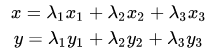

-- for plotting tetrahedrons:
         "you draw a point by drawing a point"
         "you draw a line by connecting its points"
         "you draw a triangle by connecting its lines"
         "you draw a tetrahedron by connecting its triangles"
         "you draw a 4-simplex by connecting its tetrahedrons"
        .... etc.

<IPython.core.display.Javascript object>


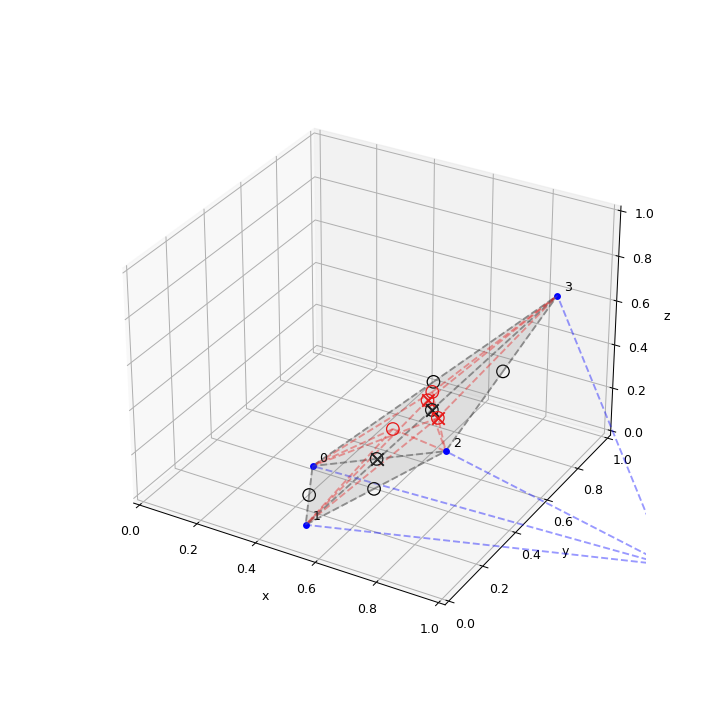

In [10]:
%matplotlib notebook
tet = spatial.Delaunay(X)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = "3d")

tri = list()
kdtree = spatial.KDTree(X) # X is in R^d
cech_complex = set()

def filter_subfaces(simplex, filtration = set(), ax = None):
    if len(simplex) == 0:
        return filtration
    elif len(simplex) == 1:
        return filtration.union({(simplex,0.0)})
    
    sub = combinations(simplex, len(simplex)-1)
    F = set()
    for f in sub:
        F = F.union({filter_subfaces(
            simplex = f,
            filtration = filtration,
            ax = ax
        )})
        
    return filtration.union({ F })

for t in tet.simplices:
    filtration = filter_subfaces(t, ax = ax)
    cech_complex = cech_complex.union(filtration)
    
    for sf in powerset(t):
        if len(sf) == 0:
            continue
        elif len(sf) == 1:
            cech_complex = cech_complex.union({ (sf, 0.0) })
            continue
        elif len(sf) == 2:
            plot_color = "black"
        elif len(sf) == 3:
            plot_color = "red"
            tri.append(sf)
        else:
            assert False
        
        # https://westy31.home.xs4all.nl/Circumsphere/ncircumsphere.htm
        content_inv = np.linalg.inv(cayley_menger_matrix( X[sf,:] ))
        circumradius = np.sqrt(content_inv[0,0]/-2)
        circumcentre = content_inv[1:,0].dot( X[sf,:] )

        ax.scatter(*tuple(circumcentre), color = plot_color, marker = "o", facecolors='none', s = 100, alpha = 1)
        
        # a face is Gabriel if there are no other vertices within the d-ball
        _,nn = kdtree.query(circumcentre, k = len(sf))
        assert len(nn) >= len(sf)
        
        if set(nn) != set(sf):
            ax.scatter(
                *tuple(circumcentre),
                color = plot_color,
                marker = "x",
                s = 100,
                alpha = 1
            )

        cech_complex = cech_complex.union({ (sf, circumradius) })
        
        for y in X[sf, :]:
            ax.plot(
                [circumcentre[0],y[0]],
                [circumcentre[1],y[1]],
                [circumcentre[2],y[2]],
                "--",
                color = plot_color,
                alpha = 0.4
            )
#
cech_complex = list(cech_complex)
plt_tri = a3.art3d.Poly3DCollection(X[tri, :])
plt_tri.set_alpha(0.1)
plt_tri.set_color('grey')
ax.add_collection3d(plt_tri)

for i,x in enumerate(X):
    ax.scatter(*tuple(x), color = "blue")
    ax.text(*tuple(x+0.015), str(i))
    
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [11]:
print(len(cech_complex))
print(sorted(cech_complex, key = lambda t: t[1]))

15

[
    ((3,), 0.0),
    ((1,), 0.0),
    ((0,), 0.0),
    ((2,), 0.0),
    ((1, 0), 0.1506743866835675),
    ((1, 2), 0.34413933305891226),
    ((3, 2), 0.35509837750597556),
    ((2, 0), 0.4117108215189516),
    ((1, 2, 0), 0.42804001240267464),
    ((3, 0), 0.5042648391721445),
    ((3, 2, 0), 0.5093760261501183),
    ((1, 3), 0.5439969918453013),
    ((1, 3, 0), 0.5482754572570822),
    ((1, 3, 2), 0.5564443747147196),
    ((1, 3, 2, 0), 1.0968207652526005)
]

In [9]:
import gudhi as gd
skeleton = gd.AlphaComplex(
    points = X
)
st = skeleton.create_simplex_tree()
gudhi_cech_complex = list(map(lambda t : (t[0],np.sqrt(t[1])), st.get_filtration()))
print(len(gudhi_cech_complex))
print(sorted(gudhi_cech_complex, key = lambda t : t[1]))

15

[
    ([0], 0.0),
    ([1], 0.0),
    ([2], 0.0),
    ([3], 0.0),
    ([0, 2], 0.1506743866835675),
    ([0, 1], 0.34413933305891226),
    ([1, 3], 0.35509837750597556),
    ([1, 2], 0.42804001240267475),
    ([0, 1, 2], 0.42804001240267475),
    ([2, 3], 0.5042648391721445),
    ([1, 2, 3], 0.5093760261501183),
    ([0, 3], 1.0968207652526243),
    ([0, 1, 3], 1.0968207652526243),
    ([0, 2, 3], 1.0968207652526243),
    ([0, 1, 2, 3], 1.0968207652526243)
]

In [7]:
print(spatial.distance_matrix(X,X)/2)

[[0.         0.15067439 0.41171082 0.50426484]
 [0.15067439 0.         0.34413933 0.54399699]
 [0.41171082 0.34413933 0.         0.35509838]
 [0.50426484 0.54399699 0.35509838 0.        ]]